## <span style="color:orange">Use Case: Co-locate satellite and in-situ data for cross-validation</span>

#### User Story
As a coastal applications researcher, I would like to co-locate in-situ measurements and satellite data near the European coast for cross-validation of data or model validation, during the winter of 2019. (*Note: this user stroes was developed to demo at the 2nd Annual SWOT Applications Early Adopter Hackweek, 8 March 2021.)

#### Learning Objectives
- Co-locate remote sensing data from the Earthdata Cloud archive with in-situ measurements from another provider, programmatically using the Earthdata CMR amd Harmony APIs. 
- Workflow can be conducted either locally or in the cloud (i.e. it is compute environment agnostic). 
- While capabilities demoed here are shown through an oceanography example, these use cases and examples can be applied as building blocks for developing other user workflows with PO.DAAC and Earthdata datasets, across a range of science and applications disciplines, including for example terrestrial hydrology, coastal, or cryosphere. 
- Note: Searching for NASA Earthdata data given point-based observation locations can also be done via the NASA Earthdata Search user interface https://search.earthdata.nasa.gov/search, in addition to programmatically (as shown here).

#### Datasets used
- Argo floats https://argo.ucsd.edu/
- MODIS-Aqua L2 SST https://podaac.jpl.nasa.gov/dataset/AMSRE-REMSS-L2P-v7a
- MUR L4 SST https://registry.opendata.aws/mur/

#### Main Steps in Workflow
1. Define study region and period of time of interest: Atlantic Ocean west of Portugal and Morocco, January 2019
2. Get in-situ Argo floats using the Argo API and prepapre the Argo data (select Argo SST for one float during its journey in Jan 2019 at the top pressure level i.e. nearest the ocean surface)
3. Get coincident SST observed by the MODIS satellite, from the NASA Earthdata Cloud (in AWS)
    - Search Earthdata Cloud satellite data for collection of interest (MODIS-Aqua L2) (using the CMR API)
    - Extract satellite data at the in-situ location for direct comparison (using the Harmony API)
    - Download locally (from the cloud archive), or download to your cloud storage or compute space if working within the AWS cloud
    - Quality control the MODIS data with daytime and quality flag filters    
4. Plot time series comparing the in-situ and satellite data at in-situ location(s)
5. Validate with a third dataset, MUR L4 SST (once version stored in the *AWS Registry of Open Data* - public data access)

*Note: in order to currently access PO.DAAC Cloud Pathfinder datasets such as MODIS SST L2 from the Earthdata Cloud, your Earthdata login username needs to be added to an restrcited early access list (during the transition period of migrating PO.DAAC data to the Earthdata Cloud). Please contact podaac@podaac.jpl.nasa.gov to make that request.*


<img src="Colocate_insitu_MODIS_MUR.jpeg">

---------------

### Requirements

**Import modules**: The Python ecosystem is organized into modules.  A module must be imported before the contents of that modules can be used.  It is good practice to import modules in the first code cell of a notebook or at the top of your script.  Not only does this make it clear which modules are being used, but it also ensures that the code fails at the beginning because one of the modules is not installed rather half way through after crunching a load of data.

For some modules, it is common practice to shorten the module names according to accepted conventions.  For example, the plotting module `matplotlib.pyplot` is shortened to `plt`.  It is best to stick to these conventions rather than making up your own short names so that people reading your code see immediately what you are doing. 

In [1]:
from netrc import netrc
from platform import system
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from glob import glob
from os import environ
from os.path import join, isfile, basename, abspath, expanduser
from datetime import datetime
from folium.plugins import MarkerCluster
import folium
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import numpy as np
import requests
import json
import time

matplotlib.rc('font', **{'family' : 'sans-serif', 'weight': 'normal', 'size': 16})

!mkdir -p resources/

### Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

The `setup_earthdata_login_auth` function will allow Python scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 

In [2]:
TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str='cmr.earthdata.nasa.gov'):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']


def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

Username: jmcnelis
Password: ········


### Study region and period

Set some "master" inputs to define the time and place contexts for our case studies in the ipynb. 

In [3]:
# The timeframe of interest (Argovis API limit == 3 months):
start_date = "2019-01-01"
end_date   = "2019-01-31"

# The area/region of interest by latitude/longitude:
aoi_minlon = -26.0
aoi_minlat = 30.0
aoi_maxlon = -12.0
aoi_maxlat = 40.0

Plot the spatial extent of our study area with a blue polygon:

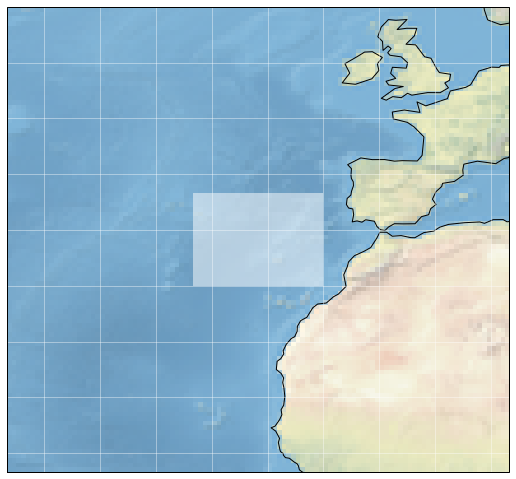

In [4]:
ax = plt.subplot(projection=ccrs.PlateCarree())

ax.figure.set_figheight(9)
ax.figure.set_figwidth(9)

ax.add_patch(mpatches.Rectangle(xy=[aoi_minlon, aoi_minlat], 
                                width=aoi_maxlon-aoi_minlon, 
                                height=aoi_maxlat-aoi_minlat,
                                facecolor='white',
                                alpha=0.5,
                                transform=ccrs.Geodetic())
             )
ax.set_extent((aoi_minlon-20., 
               aoi_maxlon+20.,
               aoi_minlat-20.,
               aoi_maxlat+20.), crs=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(color="white", alpha=0.5)
plt.show()

## Access temperature profiles from ArgoVis API

ArgoVis is an API and visualization service that provides access to Argo float profiles. The endpoint for requesting profile data is given in the cell below:

In [5]:
argo_api_endpoint = 'https://argovis.colorado.edu/selection/profiles/?'

print(argo_api_endpoint)

https://argovis.colorado.edu/selection/profiles/?


Create the AOI polygon in required XY format, make it a string, and collect the dictionary of API parameters:

In [6]:
argo_api_aoi = [[[aoi_minlon, aoi_minlat], 
                 [aoi_minlon, aoi_maxlat], 
                 [aoi_maxlon, aoi_maxlat],
                 [aoi_maxlon, aoi_minlat],
                 [aoi_minlon, aoi_minlat]]]

argo_api_params = {
    'startDate': start_date.replace("-0","-"),     # 1.
    'endDate': end_date.replace("-0","-"),         # 1. No leading zeros in start/end dates
    'shape': str(argo_api_aoi).replace(" ",""),    # 2. Array of XY vertices for AOI polygon
    #'presRange': "[0,30]"                         # 3. We wont limit by pressure range
}

argo_api_params

{'startDate': '2019-1-1',
 'endDate': '2019-1-31',
 'shape': '[[[-26.0,30.0],[-26.0,40.0],[-12.0,40.0],[-12.0,30.0],[-26.0,30.0]]]'}

Submit the request parameters to the Argovis API. You should receive a JSON response back. Print the number of profiles inside our AOI:

In [7]:
argo_api_response = requests.get(url=argo_api_endpoint, params=argo_api_params)

# Load the response from JSON if the response status is 200:
if argo_api_response.status_code == 200:
    argo_profiles = argo_api_response.json()
    print(len(argo_profiles))
else:
    # Otherwise dump the text for more clues:
    print(argo_api_response.text)

41


### Prepare profile data for further analysis

Concatenate the list of metadata dictionaries returned for the argos into a table and update a few of its columns with Pythonic types:

In [8]:
argo_df = pd.DataFrame(argo_profiles).sort_values("date")

# Add a column with pandas datetime objects for easier indexing
argo_df['datetime'] = pd.to_datetime(argo_df['date'])
# And then replace the original date column with Python dates
argo_df['date'] = argo_df.datetime.apply(lambda x: x.date).tolist()

# Add two columns of sanitized lats/lons to the data frame
argo_df['lat'] = argo_df['roundLat'].astype(float).tolist()
argo_df['lon'] = argo_df['roundLon'].astype(float).tolist()

argo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 40 to 0
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   _id                           41 non-null     object             
 1   POSITIONING_SYSTEM            41 non-null     object             
 2   DATA_CENTRE                   41 non-null     object             
 3   PI_NAME                       41 non-null     object             
 4   WMO_INST_TYPE                 41 non-null     object             
 5   VERTICAL_SAMPLING_SCHEME      41 non-null     object             
 6   DATA_MODE                     41 non-null     object             
 7   PLATFORM_TYPE                 41 non-null     object             
 8   measurements                  41 non-null     object             
 9   station_parameters            41 non-null     object             
 10  pres_max_for_TEMP             41 non-nul

You can download profiles in netCDF format from the FTP link stored in the *nc_url* fields of the response. Here's the URL for the first of the profiles:

In [9]:
print(argo_df.iloc[0].nc_url)

ftp://ftp.ifremer.fr/ifremer/argo/dac/coriolis/6902663/profiles/R6902663_124.nc


Display a table summarizing the space/time characteristics of eaach profile:

In [10]:
argo_df[['platform_number', 'cycle_number', 'datetime', 'lon', 'lat']] #, 'measurements']]

,platform_number,cycle_number,datetime,lon,lat
40,6902663,124,2019-01-01 20:14:00+00:00,-17.383,35.601
39,6901260,49,2019-01-02 05:43:00+00:00,-12.812,37.707
38,6901143,228,2019-01-02 09:22:20+00:00,-21.083,32.254
37,6902664,124,2019-01-02 20:28:00+00:00,-18.411,34.985
36,3901643,43,2019-01-04 06:13:00+00:00,-22.429,37.556
35,3901942,48,2019-01-05 20:23:30+00:00,-15.286,35.316
34,6901262,22,2019-01-06 05:42:59.999000+00:00,-17.967,34.228
33,3901932,22,2019-01-06 05:49:00+00:00,-19.904,33.428
32,1901688,288,2019-01-07 03:11:53+00:00,-23.134,34.258
31,6901260,50,2019-01-07 05:26:00+00:00,-12.887,37.905


*Now plot argo profile locations on an interactive map.*

This plot uses folium/leaflet. Hover/click the clusters (which correspond to specific Argo float platforms) to zoom to the groups of individual profiles and display metadata about them:

In [11]:
def _get_tooltip(profile: dict):
    return """<b>Date</b>: {date}<br>
              <b>Profile ID</b>: {_id}<br>
              <b>Platform ID</b>: {platform_number}<br>
              <b>Latitude</b>: {lat}<br>
              <b>Longitude</b>: {lon}<br>""".format(**profile)


m = folium.Map(location=[argo_df['lat'].mean(), argo_df['lon'].mean()], 
               tiles="Stamen Terrain",
               zoom_start=5, )

# Loop over list of unique platform_numbers (floats)
unique_argo_platform_numbers = argo_df.platform_number.unique().tolist()

for i, platform in enumerate(unique_argo_platform_numbers):
    # Get row(s) for the current platform
    p = argo_df[argo_df['platform_number']==platform]
    # Make an empty marker cluster to add to the map widget
    cluster = MarkerCluster(name=p['platform_number'])
    # Make markers in a loop and add to the cluster:
    for c in p['cycle_number'].tolist():
        # Select the row for the current profile ('cycle')
        profile = p[p['cycle_number']==c].iloc[0]
        # Create a new marker and add it to the cluster
        cluster.add_child(folium.Marker(
            location=[profile['lat'], profile['lon']],
            tooltip=_get_tooltip(profile.to_dict())))
    m.add_child(cluster)

display(m)

#### Reformat profile data into data frames

The in situ measurements temperature, pressure, and salinity readings collected during each profile are returned inside the JSON response.

The format of the *measurements* field is perfect for conversion to *pandas* data frames. Apply *pandas.DataFrame* over the entire measurements column to make a pandas.Series of data frames, and replace the existing content in the *measurements* column:

In [12]:
argo_df['measurements'] = argo_df['measurements'].apply(pd.DataFrame).tolist()

# Print statistical summary of the table content:
argo_df.iloc[0].measurements.describe()

,temp,pres,psal
count,105.000000,105.000000,105.000000
mean,11.579429,794.390476,35.832990
std,4.726514,655.512828,0.433002
min,4.053000,6.000000,35.073000
25%,8.096000,146.000000,35.597000
50%,10.885000,713.000000,35.765000
75%,15.750000,1363.000000,36.128000
max,18.418000,2010.000000,36.504000


**Plot temperature at the minimum pressure for each profile**

This cell applies a lambda over the measurements column to slice the row corresponding to the minimum pressure bin for each profile and returns the corresponding temperature measurement:

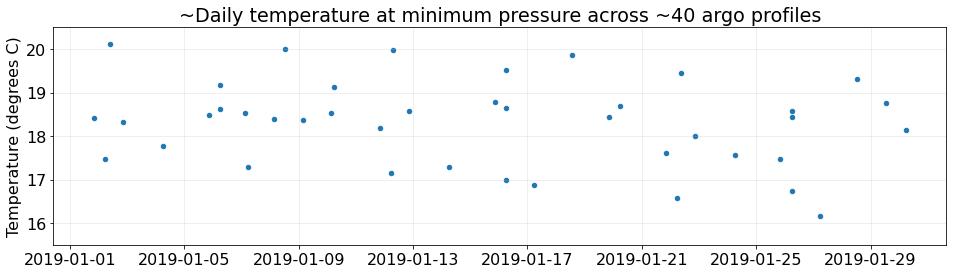

In [13]:
def _get_prof_temp_at_pres_min(x):
    return x[x['pres']==x['pres'].min()]['temp'].item()

# Apply the fuunction over the column of measurements tables
argo_df['temp_at_pres_min'] = argo_df['measurements'].apply(_get_prof_temp_at_pres_min).tolist()

# Plot temperature measured nearest to the sea surface for each profile 
argo_df.plot.scatter(x="datetime", y="temp_at_pres_min", figsize=(16, 4))
plt.title("~Daily temperature at minimum pressure across ~40 argo profiles")
plt.xlabel(None)
plt.ylabel("Temperature (degrees C)")
plt.ylim(15.5, 20.5)
plt.grid(alpha=0.25)

#### Select an *Argo of Interest* and its *platform_number*

See which floats had the most profiles within our timeframe/area of interest:

In [14]:
argo_df.groupby("platform_number").count()['cycle_number']

platform_number
1901688    6
3901643    3
3901932    3
3901942    3
6901143    3
6901260    6
6901262    3
6901273    3
6902552    3
6902663    3
6902664    3
6902785    2
Name: cycle_number, dtype: int64

Choose a float with six profiles to study further during the remainder of the notebook.

In [15]:
target_argo = 6901260

# Select rows (profiles) for the desired platform:
argo_skinny = argo_df[argo_df.platform_number==target_argo].copy()

argo_skinny.describe()

,pres_max_for_TEMP,pres_min_for_TEMP,pres_max_for_PSAL,pres_min_for_PSAL,max_pres,date_qc,lat,lon,position_qc,cycle_number,platform_number,BASIN,temp_at_pres_min
count,6.000000,6.0,6.000000,6.0,6.000000,6.0,6.000000,6.000000,6.0,6.000000,6.0,6.0,6.000000
mean,1992.666667,6.0,1992.666667,6.0,1992.666667,1.0,38.131167,-13.030667,1.0,51.500000,6901260.0,1.0,16.921000
std,21.500388,0.0,21.500388,0.0,21.500388,0.0,0.297238,0.168997,0.0,1.870829,0.0,0.0,0.495337
min,1961.000000,6.0,1961.000000,6.0,1961.000000,1.0,37.707000,-13.265000,1.0,49.000000,6901260.0,1.0,16.153000
25%,1980.500000,6.0,1980.500000,6.0,1980.500000,1.0,37.940500,-13.132500,1.0,50.250000,6901260.0,1.0,16.643250
50%,1994.500000,6.0,1994.500000,6.0,1994.500000,1.0,38.156500,-13.037000,1.0,51.500000,6901260.0,1.0,17.014000
75%,2010.750000,6.0,2010.750000,6.0,2010.750000,1.0,38.350000,-12.910750,1.0,52.750000,6901260.0,1.0,17.263250
max,2014.000000,6.0,2014.000000,6.0,2014.000000,1.0,38.484000,-12.812000,1.0,54.000000,6901260.0,1.0,17.479000


## Access *sea surface temperature* from MODIS

The user guide for MODIS Level 2 Sea Surface Temperature (SST) from GHRSST is available on the PO.DAAC Drive: https://podaac-tools.jpl.nasa.gov/drive/files/OceanTemperature/ghrsst/docs/GDS20r5.pdf

We will access L2 SST data for our AOI and time period of interest by submitting two subset requests to the [Harmony API](https://harmony.earthdata.nasa.gov/).

**Redefine the AOI to the minimum XY bounds of selected profiles**

Simply replace the *`aoi_*`* Python variables with min/max of the *lat* and *lon* columns in the new *argo_skinny* data frame:

In [16]:
aoi_minlon = argo_skinny.lon.min()
aoi_maxlon = argo_skinny.lon.max()
aoi_minlat = argo_skinny.lat.min()
aoi_maxlat = argo_skinny.lat.max()

aoi_minlon, aoi_minlat, aoi_maxlon, aoi_maxlat

(-13.265, 37.707, -12.812, 38.484)

**Search the Common Metadata Repository (CMR) for its unique *concept-id***

The API requires a dataset identifier that we must obtain from CMR. In the next cell, submit a request to the CMR API to grab the metadata for to the dataset/collection.

In [17]:
modis_results = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': "MODIS_A-JPL-L2P-v2019.0",
            'token': _token}
).json()

# Select the first/only record in the JSON response:
modis_coll = modis_results['items'][0]

# Select the 'concept-id' from the 'meta' dictionary:
modis_ccid = modis_coll['meta']['concept-id']

modis_ccid

'C1940473819-POCLOUD'

#### Request subsets from the Harmony API

We will submit two requests to the [Harmony API](https://harmony.earthdata.nasa.gov/). The API is under active development, and it's therefore recommended that you test your input parameters in the [Swagger API interface](https://harmony.earthdata.nasa.gov/docs/api/#).

The next cell joins the base url for the API to the concept-id obtained above. Run the cell and print the complete url to confirm:

In [18]:
harmony_url = "https://harmony.earthdata.nasa.gov"
harmony_url_modis = f"{harmony_url}/{modis_ccid}/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?"

print(harmony_url_modis)

https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?


Make a dictionary of subset parameters and format the values to meet requirements of the Harmony API. (See the Swagger UI linked above for more information about those requirements.)

*Note how I've commented out the `time` parameter for the second half of January.* I requested the first 15 days and then the second 15 days in two requests to get the whole month. 

Here we print the parameters for the first request:

In [19]:
harmony_params_modis1 = {
    'time': f'("{start_date}T00:00:00.000Z":"2019-01-15T23:59:59.999Z")',
    'lat': f'({aoi_minlat}:{aoi_maxlat})',
    'lon': f'({aoi_minlon}:{aoi_maxlon})',
}

harmony_params_modis2 = {
    'time': f'("2019-01-16T00:00:00.000Z":"{end_date}T23:59:59.999Z")',
    'lat': f'({aoi_minlat}:{aoi_maxlat})',
    'lon': f'({aoi_minlon}:{aoi_maxlon})',
}

harmony_params_modis1

{'time': '("2019-01-01T00:00:00.000Z":"2019-01-15T23:59:59.999Z")',
 'lat': '(37.707:38.484)',
 'lon': '(-13.265:-12.812)'}

Complete the url by formatting the query portion using the parameters dictionary:

In [20]:
request_url_modis1 = harmony_url_modis+"subset=time{time}&subset=lat{lat}&subset=lon{lon}".format(**harmony_params_modis1)
request_url_modis2 = harmony_url_modis+"subset=time{time}&subset=lat{lat}&subset=lon{lon}".format(**harmony_params_modis2)

print(request_url_modis1)

https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=time("2019-01-01T00:00:00.000Z":"2019-01-15T23:59:59.999Z")&subset=lat(37.707:38.484)&subset=lon(-13.265:-12.812)


#### Submit the request parameters to the Harmony API endpoint

I've already submitted the two requests required to obtain full coverage for our region and timeframe of interest (the two urls in the *job_status* list below). To submit a new request, or to submit these two MODIS requests again, comment out the two items in the list like this:

```python
job_status = [
    #'https://...'
    #'https://...
]
```

It should trigger new requests in the subsequent cells.

In [21]:
job_status = [    
    "https://harmony.earthdata.nasa.gov/jobs/512ca343-3bfe-48c5-a480-9281b7348761",  # First time slice
    "https://harmony.earthdata.nasa.gov/jobs/5b29414d-3856-4e94-9568-01b32b02a951",  # Second time slice
]

The next cell should download a JSON for your new request or from the first request that I submitted while I developed this notebook.

Print the message field of the JSON response:

In [22]:
request_urls_for_modis = [request_url_modis1, request_url_modis2]

if len(job_status)==0:
    # Loop over the list of request urls:
    for r in request_urls_for_modis:
        # Submit the request and decode the response from json string to dict:
        response_modis = requests.get(r)
        # If the response came back with something other than '2xx', raise an error:
        if not response_modis.status_code // 100 == 2: 
            raise Exception(response_modis.text)
        else:
            response_data = response_modis.json()
        # Append the status endpoint to the list of 'job_status' urls:
        job_status.append(response_data['links'][0]['href'])
else:
    response_data = requests.get(job_status[0]).json()

response_data['message']

'The job has completed successfully'

*To process new subsets covering the full month of January, you will need to run the cell above one more time to submit a request for days of the year 016-031.*

Successful requests to the API will respond with a JSON that starts like this:

```json
{
  "username": "jmcnelis",
  "status": "running",
  "message": "The job is being processed",
  "progress": 0,
  "createdAt": "2021-02-25T02:09:35.972Z",
  "updatedAt": "2021-02-25T02:09:35.972Z",
    ...
```

The example above is truncated to the first several lines for the sake of space.

**Monitor the status of an in-progress job**

Select the `status` URL(s) from the list(s) of `links`:

In [23]:
if len(job_status)==0:
    try:
        job_status = [l['href'] for l in response_data['links'] if l['title']=="Job Status"]
    except (KeyError, IndexError) as e:
        raise e

print(job_status)

['https://harmony.earthdata.nasa.gov/jobs/512ca343-3bfe-48c5-a480-9281b7348761', 'https://harmony.earthdata.nasa.gov/jobs/5b29414d-3856-4e94-9568-01b32b02a951']


Run the next cell to monitor the status of as many requests as you need.

It will loop over the `job_status` list and wait for all the requests to finish processing. (It terminates when the `status` field of the JSON response _does not_ contain the string `"running"`.)

In [24]:
wait = 10       # The number of seconds to wait between each status check
completed = {}  # A dict of JSON responses for completed jobs

# Loop repeatedly to check job status. Wait before retrying.
while True:
    for j in job_status:  # Iterate over list of job urls
        if j in completed:  # Skip if completed.
            continue
        # Get the current job's status as a JSON object.
        job_data = requests.get(j).json()
        if job_data['status']!='running':
            completed[j] = job_data  # Add to 'completed' if finished
    # Break loop if 'completed' dictionary contains all jobs.
    if len(completed)==2:
        break
    # If still processing, print a status update and wait ten seconds.
    print(f"# Job(s) in progress ({len(completed)+1}/{len(job_status)})")
    time.sleep(wait)
    
print(f"\n{'&'*40}\n%\t\tDONE!\n{'&'*40}\n")


&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
%		DONE!
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&



The final response(s) are *massive* whenever your subset results in a large number of output granules. Print everything but the `links` here:

In [25]:
print(json.dumps({k:v for k, v in job_data.items() if k!="links"}, indent=2))

{
  "username": "jmcnelis",
  "status": "successful",
  "message": "The job has completed successfully",
  "progress": 100,
  "createdAt": "2021-03-01T21:40:56.233Z",
  "updatedAt": "2021-03-01T21:42:59.337Z",
  "request": "https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=time(%222019-01-16T00%3A00%3A00.000Z%22%3A%222019-01-31T23%3A59%3A59.999Z%22)&subset=lat(37.707%3A38.484)&subset=lon(-13.265%3A-12.812)",
  "numInputGranules": 55,
  "jobID": "5b29414d-3856-4e94-9568-01b32b02a951"
}


Now look at the first url that points to a subset file (skip the first two because they point to other stuff about the order):

In [26]:
print(json.dumps(job_data['links'][2], indent=2))

{
  "href": "https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/56d7a026-a935-46f4-8dc0-a645831aed84/20190116023001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4",
  "title": "20190116023001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4",
  "type": "application/x-netcdf4",
  "rel": "data",
  "bbox": [
    -13.3,
    37.7,
    -12.8,
    38.5
  ],
  "temporal": {
    "start": "2019-01-16T02:30:01.000Z",
    "end": "2019-01-16T02:34:59.000Z"
  }
}


This cell collects all the output links (Python dicts) from our requests in a list and prints the total number of outputs:

In [27]:
job_links = []

for j in list(completed.values()):
    for l in j['links']:
        if l['href'].endswith("subsetted.nc4"):
            job_links.append(l)

print(len(job_links))

74


##### Prepare subset data for further analysis

Get the subset metadata as `pandas.DataFrame`. We can use *apply* logic to calculate stats over the time series in subsequent steps. Print the number of rows to confirm. (Should match above)

In [28]:
subsets_df = pd.DataFrame(data=[{**l, **l['temporal']} for l in job_links])

print(subsets_df.index.size)

74


**Select day/drop night observations**

Add a day/night flag column to the table. Apply a function over the `href` column to check the source filename for a string indicating day/night for the swath:

In [29]:
subsets_df['daytime'] = subsets_df['href'].apply(lambda x: 'MODIS_A-N' not in x)

subsets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   href      74 non-null     object
 1   title     74 non-null     object
 2   type      74 non-null     object
 3   rel       74 non-null     object
 4   bbox      74 non-null     object
 5   temporal  74 non-null     object
 6   start     74 non-null     object
 7   end       74 non-null     object
 8   daytime   74 non-null     bool  
dtypes: bool(1), object(8)
memory usage: 4.8+ KB


And finally, reformat the *start* timestamps as a new column containing pandas datetime objects instead of strings. Then, add one more column containing a date object (rather than the full datetime timestamp) which we'll use to aggregate the data before plotting.

In [30]:
# Add new 'datetime' column so that we aren't working with strings:
subsets_df['datetime'] = pd.to_datetime(subsets_df['start'])

# Add new 'date' column for aggregation during the final steps of the workflow:
subsets_df['date'] = subsets_df.datetime.apply(lambda x: x.date()).tolist()

subsets_df.date.iloc[0]

datetime.date(2019, 1, 1)

Now map the coverages of the subsets using their bounding boxes, which we received as part of each link object:


```python
# Use numpy wizardy to get arrays of bbox coordinates for all subsets:
minlons, minlats, maxlons, maxlats = np.array(subsets_df.bbox.tolist()).T


def _get_coverage_tooltip(s: dict):
    content = []
    for k, v in s.items():
        if k not in ['href', 'temporal']:
            content.append(f"<b>{k}</b>: {v}")
    return f"<p>{'<br>'.join(content)}</p>"


def _map_coverage_Polygon(subset, map_object):
    # Get the subset bbox components as four separate python variables:
    xmin, ymin, xmax, ymax = subset['bbox']
    # Return a Polygon object with embedded metadata about the subset:
    folium.Polygon(
        # Arrange bbox components in a closed vector:
        locations=[[[ymin, xmin], [ymin, xmax], [ymax, xmax], [ymax, xmin], [ymin, xmin]]],
        # Call function defined above to get a tooltip:
        tooltip=_get_coverage_tooltip(subset)
    # Call 'add_to' method to plot it on the map:
    ).add_to(map_object)


# Create a new folium map instance
m = folium.Map(location=[(minlats.min()+maxlats.max())/2, 
                         (minlons.min()+maxlons.max())/2], zoom_start=7)

# Iterate and map the spatial coverages:
for ix, row in subsets_df.iterrows():
    _map_coverage_Polygon(subset=row.to_dict(), map_object=m)


display(m)
```

### Accessing outputs from your subset request

Now we will download all the netCDF subsets to the local workspace. (I'm inside AWS as I develop this ipynb.) Set a target directory and create it if needed:

In [31]:
target_dir = f"resources/data/"

!mkdir -p $target_dir

This function should handle downloads reliably--test by downloading the first netCDF subset from our table (*subsets_df*):

In [32]:
def download_target_file(url: str, force: bool=False):
    # Determine the target path for the download
    target_file = join(target_dir, basename(url))
    if isfile(target_file) and force is False:
        print(f"# File already exists. Skipping...\n({basename(url)})\n")
        return
    print(f"# File downloading...\n({basename(url)})\n")
    # Open a remote connection for download stream/write to disk:
    with requests.get(url) as r:
        # Raise exception if response has status other than '2xx':
        if not r.status_code // 100 == 2: 
            raise Exception(r.text)
        else:
            # Otherwise write the file to disk:
            with open(target_file, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
                        

# Test the download function by passing the URL for the first subset in the `subsets` table:
download_target_file(url=subsets_df['href'].iloc[0])

# Join the string path to the target file that should have just downloaded.
test_nc4 = join(target_dir, basename(subsets_df['href'].iloc[0]))

print("The first file downloaded successfully:", isfile(test_nc4))

# File already exists. Skipping...
(20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

The first file downloaded successfully: True


Make sure you can dump the header of that file with *ncdump*. (The output below is truncated.)

In [33]:
!ncdump -h $test_nc4 | head -20

netcdf \20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted {
dimensions:
	nj = 92 ;
	ni = 42 ;
	time = 1 ;
variables:
	float lat(nj, ni) ;
		lat:_FillValue = -999.f ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:valid_min = -90.f ;
		lat:valid_max = 90.f ;
		lat:comment = "geographical coordinates, WGS84 projection" ;
		lat:coverage_content_type = "coordinate" ;
	float lon(nj, ni) ;
		lon:_FillValue = -999.f ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;


NetCDF file format errors indicate that the download was not successful. *cat* the file for more clues. Read and plot the *sea_surface_temperature* variable:

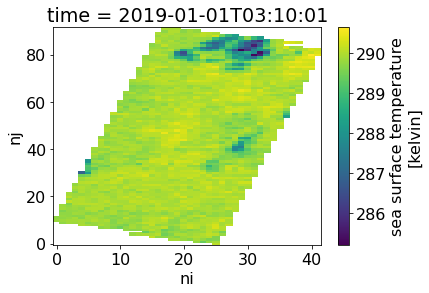

In [34]:
with xr.open_dataset(test_nc4) as ds:
    ds.sea_surface_temperature[0].plot()

#### Download all the netCDF subsets

Get the links in the *href* column in a loop:

In [35]:
for u in subsets_df['href'].tolist():
    download_target_file(u)

# File already exists. Skipping...
(20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190101141501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190102021501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190102132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190103030000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190103140501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190104020501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190104034001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190104034501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0

The next cell adds a column of absolute paths to the netCDF files to the data frame *subsets_df*:

In [36]:
subsets_df['path'] = subsets_df['href'].apply(lambda x: abspath(join(target_dir, basename(x))))

isfile(subsets_df['path'].iloc[0])

True

#### Limit to daytime MODIS observations

Select just the *daytime* observations into a new data frame. (Remember we added a *daytime* column during a previous step.)

In [37]:
subsets_day = subsets_df[subsets_df.daytime==True].copy()

print(subsets_day.index.size, "of", subsets_df.index.size, "MODIS acquisitions were collected during daytime")

37 of 74 MODIS acquisitions were collected during daytime


#### Data quality

The *quality_level* variable describes the observation quality for each pixel in the L2 swaths. Values are assigned between 1 and 6 corresponding to these quality levels:

1. no_data
2. bad_data
3. worst_quality
4. low_quality
5. acceptable_quality
6. best_quality

The next cell plots the masked SST grid for the first daytime observations:

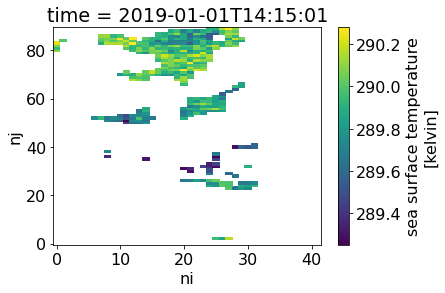

In [38]:
with xr.open_dataset(subsets_day.iloc[0].path) as ds:

    # Create a mask for pixels that are 
    quality_mask = ds.quality_level[0]==5

    # Fill pixels where ###### with np.nan:
    masked_ds = ds.where(quality_mask)

    # Plot the resulting array of sea surface temperature:
    masked_ds.sea_surface_temperature[0].plot()

### Plot time series from multiple data sources

Roll the logic above into a few map-able functions that group the SST data by day to produce (up to) one daily mean.

>#### Apply filter and mean in two functions
>
>`get_user_stat` reads the input netCDF and applies some user-specified function to the dataset to render the desired output, then closes the file.
>
>The second function `_masked_mean` filters and calculates the XY mean of the *sea_surface_temperature* variable. (You could replace this function with your own to do something different.)

Test the combined routine against the first file in the daytime MODIS table:

In [39]:
subsets_day['path'].iloc[0]

'/Users/jmcnelis/tmp/swoteafix/resources/data/20190101141501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4'

In [40]:
import warnings

def get_user_stat(netcdf, function):
    with xr.open_dataset(netcdf) as ds:  
        output = function(ds)
    return output


def _masked_mean(ds):
    '''Produce any output stat/object you want in this function'''
    # Create a mask for pixels that are 
    quality_mask = ds.quality_level[0]>=5
    # Fill pixels with np.nan where quality_level is less than 4:
    masked_ds = ds.where(quality_mask)
    # Ignore warnings about calculating mean over an empty array:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # Calculate mean over the XY dimensions (nj, ni in this case)
        value = masked_ds['sea_surface_temperature'].mean(['nj', 'ni']).data.item()
    #value = np.nanmean(masked_sst)
    return value

val = get_user_stat(subsets_day['path'].iloc[0], function=_masked_mean)

val-273.15  # subtract 273.15 to convert Kelvin to Celsius

16.743005371093773

That should give a reasonable value in degrees Celsius.

##### Get means for the filtered MODIS SST time series in a new column

Apply the `_masked_mean` function over the column of subsets (i.e. netCDF4 files) to get the time series in a new column *sst_mean*:

In [41]:
subsets_day['sst_mean'] = subsets_day['path'].apply(get_user_stat, args=(_masked_mean,))-273.15

subsets_day['sst_mean'].describe()

count    15.000000
mean     16.404915
std       0.566561
min      15.284357
25%      15.921838
50%      16.546533
75%      16.833688
max      17.222162
Name: sst_mean, dtype: float64

We may need to group by the date:

In [42]:
subsets_day_means = subsets_day.groupby("date", as_index=False).mean()

subsets_day_means.describe()

,sst_mean
count,15.000000
mean,16.404915
std,0.566561
min,15.284357
25%,15.921838
50%,16.546533
75%,16.833688
max,17.222162


Now plot the two time series along the same *date* axis for visual comparison:

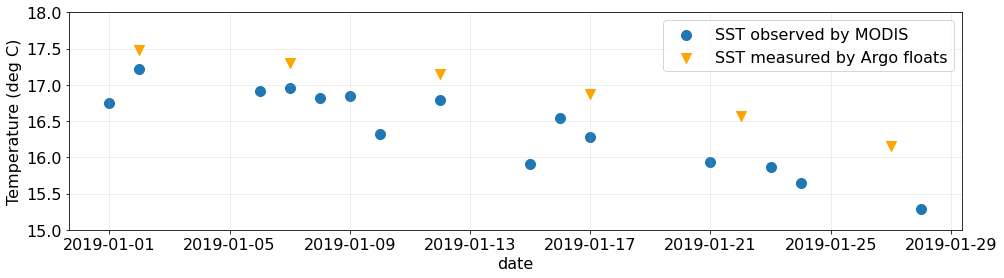

In [43]:
fig, ax = plt.subplots(figsize=(16, 4))

# Plot mean sea surface temperature from MODIS SST from GHRSST
subsets_day_means.plot.scatter(
    x="date",
    y="sst_mean", 
    label="SST observed by MODIS",
    s=100,
    ax=ax
)

# Plot mean sea surface temperature from the Argo floats
argo_skinny.plot.scatter(
    x="date",
    y="temp_at_pres_min",
    s=100,
    color="orange",
    marker="v",
    label="SST measured by Argo floats",
    ax=ax
)

# Matplotlib aesthetic treatments starting from here -->
ax.set_ylabel("Temperature (deg C)")
ax.set_ylim(15.0, 18.0)
ax.grid(alpha=0.25)

### MUR Level 4 SST from AWS Open Registry

Try plotting the summarized time series for the two datasets against MUR L4 SST from AWS Open Registry: https://registry.opendata.aws/mur/

In [44]:
import fsspec
import xarray as xr
from dask.distributed import Client

# Reference the MUR L4 SST data on the AWS Open Registry
url = 's3://mur-sst/zarr'

# Open the remote dataset from its S3 endpoint (pre-consolidated)
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)

# Slice the dataset along its X, Y, and T dimensions:
mur_L4_subset = ds['analysed_sst'].sel(
    time=slice('2019-01-01','2019-01-31'),
    lat=slice(aoi_minlat, aoi_maxlat), 
    lon=slice(aoi_minlon, aoi_maxlon),
).persist()

# Aggregate the spatial dimensions to compute the one-dimensional time series of means:
mur_L4_subset_means = mur_L4_subset.groupby("time").mean(["lon", "lat"])-273.15

print(mur_L4_subset_means)

<xarray.DataArray 'analysed_sst' (time: 31)>
dask.array<sub, shape=(31,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-01-31T09:00:00


Add the MUR time series to the subsets table so that they share the same time axis with the L2 time series:

In [45]:
subsets_day_means['L4_MUR_SST'] = mur_L4_subset_means.compute().data

Plot the result alongside our data processed throughout the notebook:

Text(0.5, 1.0, 'Daily SST from L2 MODIS, L4 MUR, and in situ measurements (January 2019)')

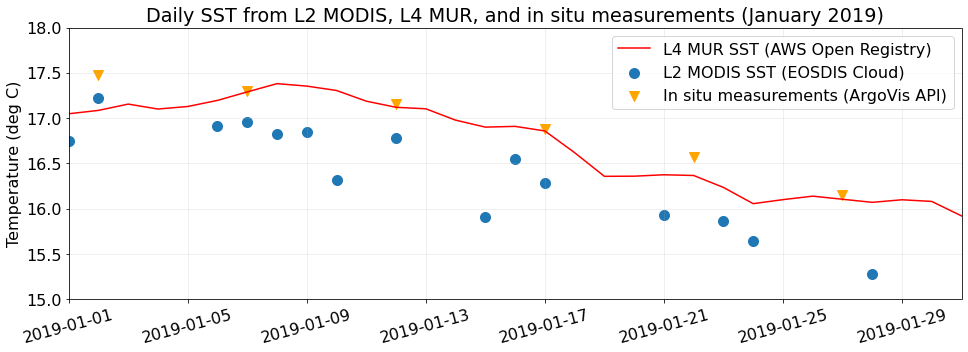

In [46]:
fig, ax = plt.subplots(figsize=(16, 5))

# Plot the L4 SST from MUR (hosted by AWS Open Registry)
subsets_day_means.plot.line(
    x="date",
    y="L4_MUR_SST",
    color="red",
    label="L4 MUR SST (AWS Open Registry)",
    ax=ax,
)

# Plot the L2 SST from GHRSST (subset through Harmony API)
subsets_day_means.plot.scatter(
    x="date",
    y="sst_mean", 
    label="L2 MODIS SST (EOSDIS Cloud)",
    s=100,
    ax=ax
)

# Plot the in situ temps measured at the surface during Argo profiles (accessed from ArgoVis)
argo_skinny.plot.scatter(
    x="date",
    y="temp_at_pres_min",
    s=100,
    color="orange",
    marker="v",
    label="In situ measurements (ArgoVis API)",
    ax=ax
)

# Matplotlib aesthetic treatments starting from here -->
plt.xticks(rotation=15)
ax.set_xlabel(None)
ax.set_xlim(subsets_day_means.date.iloc[0], subsets_day_means.date.iloc[-1])
ax.set_ylabel("Temperature (deg C)")
ax.set_ylim(15.0, 18.0)
ax.grid(alpha=0.25)
ax.set_title("Daily SST from L2 MODIS, L4 MUR, and in situ measurements (January 2019)")